In [21]:
import pandas as pd

df = pd.read_csv("data/LIACC/cpu_act_data.csv", ",")
df

,lread,lwrite,scall,sread,swrite,fork,exec,rchar,wchar,pgout,...,pgscan,atch,pgin,ppgin,pflt,vflt,runqsz,freemem,freeswap,usr
0,6,2,1036,103,114,1.00,1.00,172076,355965,0.00,...,0.00,0.00,2.00,4.00,73.60,89.00,2.0,6527,1851864,90
1,1,0,2165,205,101,0.40,1.20,43107,44139,4.80,...,181.40,0.20,85.40,88.20,19.40,161.80,3.0,130,1131931,88
2,62,77,3806,258,166,1.40,1.40,492142,268706,4.80,...,79.20,2.20,7.60,12.20,68.00,218.80,5.2,256,1314590,85
3,5,0,4721,256,177,0.99,2.58,524787,174964,14.51,...,189.86,1.99,4.17,24.85,95.63,248.91,1.0,233,972606,81
4,42,55,3949,249,244,2.60,4.60,197289,529200,4.20,...,0.00,1.40,1.80,2.20,219.60,297.20,3.4,331,1013805,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,74,49,2688,176,103,11.00,32.20,57714,38484,0.80,...,0.00,0.00,0.80,0.80,343.20,649.40,7.0,314,1096333,69
8188,29,40,1906,118,90,0.80,2.00,8175,27313,0.00,...,0.00,0.00,0.80,0.80,56.20,78.60,3.6,166,1107088,88
8189,3,0,926,90,67,0.60,1.00,5411,19322,0.00,...,0.00,0.40,0.40,0.40,53.40,154.00,1.0,1177,1020400,92
8190,4,0,418,30,29,0.80,1.00,3959,10679,0.00,...,0.00,0.00,0.20,0.20,61.00,73.20,2.4,6355,1702592,96


In [2]:
import autograd.numpy as np
import os
import string

def init_dataset(funct, num, bounds):
    dim = bounds.shape[0]
    num_src = num[0]
    num_tag = num[1]
    src_x = np.random.uniform(-0.5, 0.5, (dim, num_src))
    tag_x = np.random.uniform(-0.5, 0.5, (dim, num_tag))

    dataset = {}
    dataset['src_x']    = src_x
    dataset['tag_x']    = tag_x
    dataset['src_y']    = funct[0](src_x, bounds)
    dataset['tag_y']    = funct[1](tag_x, bounds)
    return dataset
def get_test(funct, num, bounds):
    dim = bounds.shape[1]
    dataset = {}
    dataset['test_x'] = np.random.uniform(-0.5, 0.5, (dim, num))
    dataset['test_y'] = funct[1](dataset['test_x'], bounds)
    return dataset


# bounds:  -0.5 : 1
def test1_tag(x, bounds):
    mean = bounds.mean(axis=1)
    delta = bounds[:,1] - bounds[:,0]
    x = (x.T * delta + mean).T
    ret = (x+0.03)**2 * np.sin(5.0*np.pi*(x+0.03))+0.1
    return ret.reshape(1, -1)

def test1_src(x, bounds):
    mean = bounds.mean(axis=1)
    delta = bounds[:,1] - bounds[:,0]
    x = (x.T * delta + mean).T
    ret = x**2 * np.sin(5.0*np.pi*x)
    return ret.reshape(1, -1)


# bounds:   0 : 1
def test2_tag(x, bounds):
    mean = bounds.mean(axis=1)
    delta = bounds[:,1] - bounds[:,0]
    x = (x.T * delta + mean).T
    ret = (6.0*x - 2.0)**2 * np.sin(12.*x - 4.0)
    return ret.reshape(1, -1)

def test2_src(x, bounds):
    tmp = test2_tag(x, bounds)
    mean = bounds.mean(axis=1)
    delta = bounds[:,1] - bounds[:,0]
    x = (x.T * delta + mean).T
    ret = 0.5*tmp + 10.0*(x-0.5) - 5.0
    return ret.reshape(1, -1)
    
def get_funct(funct):
    if funct == 'test1':
        return [test1_src, test1_tag]
    elif funct == 'test2':
        return [test2_src, test2_tag]
    else:
        return [test1_src, test1_tag]

In [3]:
name = 'test1'
funct = get_funct(name)
num = [80,8]
bounds = np.array([[-0.5,1.0]])

dataset = init_dataset(funct, num, bounds)
src_x = dataset['src_x']
src_y = dataset['src_y']
tag_x = dataset['tag_x']
tag_y = dataset['tag_y']

In [4]:
src_y

array([[ 1.45984237e-02, -9.44647485e-02,  5.89347326e-01,
        -5.86621294e-03,  6.33223351e-03,  1.07006452e-02,
        -1.41278192e-02,  8.72549424e-03, -2.14509566e-01,
        -1.69148654e-01,  1.44012279e-02, -8.61659702e-02,
         7.24429093e-02, -4.56909681e-03,  1.83298927e-01,
        -6.48893584e-04,  7.31239198e-01,  3.44954904e-03,
         1.30851551e-05,  8.03159832e-01,  6.60730569e-01,
        -5.77455172e-02, -3.33198791e-03,  7.80150734e-01,
         4.77566106e-03,  9.71789015e-02,  1.05159139e-02,
         4.01431900e-03,  1.18388126e-04, -4.36035306e-02,
        -1.34987867e-03, -1.88628837e-02, -4.30437584e-02,
         5.96246372e-01, -8.15368180e-02,  6.41696546e-03,
        -1.76923712e-01, -1.48998309e-02, -2.16405567e-01,
         5.69974075e-01, -1.57805976e-02,  9.49838636e-02,
        -7.07604476e-02,  7.94895843e-01,  9.45764824e-02,
         1.99975175e-02,  1.32032726e-02, -4.01141815e-02,
        -4.54718928e-01,  7.02797018e-02, -1.40044420e-0

In [5]:
tag_x

array([[-0.41923039, -0.41991015, -0.14104435, -0.17869739, -0.25356718,
         0.38000649, -0.21729897, -0.35105953]])

In [6]:
tag_y

array([[0.18759627, 0.18673693, 0.10411913, 0.10002667, 0.08992988,
        0.61097453, 0.09860508, 0.14063239]])

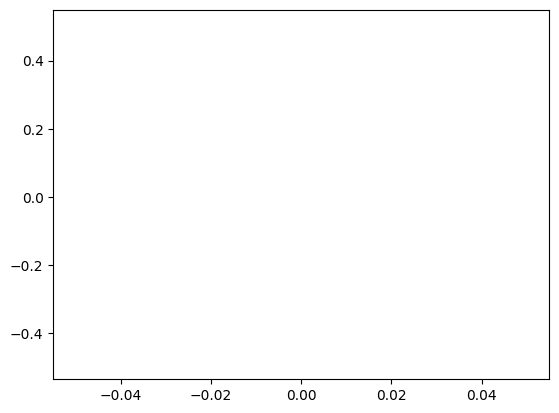

In [11]:
import matplotlib.pyplot as plt
plt.plot(src_x)
plt.show()